<a href="https://colab.research.google.com/github/4Kaustubh/Text_Conversational_Model_TOPSIS_102203194/blob/main/TOPSIS_Text_Conversational_102203194.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install transformers evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=4f17ba3297b189694494c590e8fd7ecb9f95e04fe41f19fb9bb1794948285f70
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [3]:
import torch
import warnings
from transformers import AutoTokenizer, AutoModelForCausalLM
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer

warnings.filterwarnings("ignore")

models = [
    "microsoft/DialoGPT-medium",
    "Pi3141/DialoGPT-medium-elon-2",
    "microsoft/DialoGPT-large",
    "microsoft/DialoGPT-small",
    "satvikag/chatbot"
]

prompts = [
    "What is the meaning of life?",
    "Tell me a joke.",
    "How is the weather today?",
    "What is your favorite book?",
    "Can you help me with my homework?"
]

responses = [
    "The meaning of life is subjective and varies from person to person.",
    "Sure! Why don't skeletons fight each other? They don't have the guts!",
    "The weather today is sunny with a slight breeze.",
    "My favorite book is 'The Hitchhiker's Guide to the Galaxy' by Douglas Adams.",
    "Of course! What subject is your homework about?"
]

results_dict = {}

def calculate_bleu(references, candidates):
    smoothie = SmoothingFunction().method4
    return corpus_bleu(references, candidates, smoothing_function=smoothie)

def calculate_rouge(references, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(references, candidate)
    rouge1 = scores['rouge1'].fmeasure
    rouge2 = scores['rouge2'].fmeasure
    rougeL = scores['rougeL'].fmeasure
    return rouge1, rouge2, rougeL

for model_name in models:
    bleu_scores = []
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    response_lengths = []

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained(model_name)


    input_ids = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True)["input_ids"]


    with torch.no_grad():
        output = model.generate(input_ids=input_ids, max_length=100)


    generated_responses = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output]

    for response, generated_response in zip(responses, generated_responses):
        # Calculate BLEU score
        bleu_score = calculate_bleu([[response]], [[generated_response]])
        bleu_scores.append(bleu_score)

        # Calculate ROUGE scores
        rouge1, rouge2, rougeL = calculate_rouge(response, generated_response)
        rouge1_scores.append(rouge1)
        rouge2_scores.append(rouge2)
        rougeL_scores.append(rougeL)

        # Calculate response length
        response_lengths.append(len(generated_response.split()))

    # Calculate average scores
    avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
    avg_rouge1_score = sum(rouge1_scores) / len(rouge1_scores)
    avg_rouge2_score = sum(rouge2_scores) / len(rouge2_scores)
    avg_rougeL_score = sum(rougeL_scores) / len(rougeL_scores)
    avg_response_length = sum(response_lengths) / len(response_lengths)

    # Store results
    results_dict[model_name] = {
        "BLEU": avg_bleu_score,
        "ROUGE-1": avg_rouge1_score,
        "ROUGE-2": avg_rouge2_score,
        "ROUGE-L": avg_rougeL_score,
        "Response Length": avg_response_length
    }


for model_name, scores in results_dict.items():
    print(f"Model: {model_name}")
    print(f"BLEU Score: {scores['BLEU']:.4f}")
    print(f"ROUGE-1 Score: {scores['ROUGE-1']:.4f}")
    print(f"ROUGE-2 Score: {scores['ROUGE-2']:.4f}")
    print(f"ROUGE-L Score: {scores['ROUGE-L']:.4f}")
    print(f"Average Response Length: {scores['Response Length']:.3f}")


tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/863M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


tokenizer_config.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/893 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.44G [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.75G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


tokenizer_config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/817 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Model: microsoft/DialoGPT-medium
BLEU Score: 0.0000
ROUGE-1 Score: 0.2275
ROUGE-2 Score: 0.0972
ROUGE-L Score: 0.1963
Average Response Length: 12.600
Model: Pi3141/DialoGPT-medium-elon-2
BLEU Score: 0.0000
ROUGE-1 Score: 0.2471
ROUGE-2 Score: 0.0934
ROUGE-L Score: 0.1903
Average Response Length: 12.000
Model: microsoft/DialoGPT-large
BLEU Score: 0.0000
ROUGE-1 Score: 0.3156
ROUGE-2 Score: 0.1315
ROUGE-L Score: 0.2556
Average Response Length: 8.400
Model: microsoft/DialoGPT-small
BLEU Score: 0.0000
ROUGE-1 Score: 0.2743
ROUGE-2 Score: 0.1394
ROUGE-L Score: 0.2457
Average Response Length: 7.200
Model: satvikag/chatbot
BLEU Score: 0.0000
ROUGE-1 Score: 0.2689
ROUGE-2 Score: 0.1429
ROUGE-L Score: 0.2275
Average Response Length: 9.000


In [4]:
results_dict

{'microsoft/DialoGPT-medium': {'BLEU': 0.0,
  'ROUGE-1': 0.22746031746031745,
  'ROUGE-2': 0.09721362229102168,
  'ROUGE-L': 0.19634920634920633,
  'Response Length': 12.6},
 'Pi3141/DialoGPT-medium-elon-2': {'BLEU': 0.0,
  'ROUGE-1': 0.24708437761069338,
  'ROUGE-2': 0.09340405276757786,
  'ROUGE-L': 0.19025898078529657,
  'Response Length': 12.0},
 'microsoft/DialoGPT-large': {'BLEU': 0.0,
  'ROUGE-1': 0.31560833028863716,
  'ROUGE-2': 0.13152882205513783,
  'ROUGE-L': 0.2556399951284861,
  'Response Length': 8.4},
 'microsoft/DialoGPT-small': {'BLEU': 0.0,
  'ROUGE-1': 0.2742857142857143,
  'ROUGE-2': 0.13939393939393938,
  'ROUGE-L': 0.24571428571428572,
  'Response Length': 7.2},
 'satvikag/chatbot': {'BLEU': 0.0,
  'ROUGE-1': 0.2689458689458689,
  'ROUGE-2': 0.14287179487179488,
  'ROUGE-L': 0.22746438746438744,
  'Response Length': 9.0}}

In [5]:
import pandas as pd

In [6]:
results = pd.DataFrame(results_dict).T

In [7]:
results

,BLEU,ROUGE-1,ROUGE-2,ROUGE-L,Response Length
microsoft/DialoGPT-medium,0.0,0.227460,0.097214,0.196349,12.6
Pi3141/DialoGPT-medium-elon-2,0.0,0.247084,0.093404,0.190259,12.0
microsoft/DialoGPT-large,0.0,0.315608,0.131529,0.255640,8.4
microsoft/DialoGPT-small,0.0,0.274286,0.139394,0.245714,7.2
satvikag/chatbot,0.0,0.268946,0.142872,0.227464,9.0


In [8]:
results.to_csv('results.csv')

In [9]:
import numpy as np
data=pd.read_csv("results.csv")
weights = '1,1,1,1,1'
impacts = '+,+,+,+,-'
if data.shape[1] < 3:
    raise ValueError("Input file does not contain three or more columns.")
if not data.iloc[:, 1:].apply(np.isreal).all().all():
    raise ValueError("Columns from 2nd to last do not contain numeric values only.")
if len(weights.split(',')) != len(impacts.split(',')) != data.shape[1] - 1:
    raise ValueError("Number of weights, impacts, and columns must be the same.")
if not all(impact in ['+', '-'] for impact in impacts.split(',')):
    raise ValueError("Impacts must be either +ve or -ve.")

norm_data = data.copy()
for i in range(1, data.shape[1]):
    norm_data.iloc[:, i] = data.iloc[:, i] / np.sqrt(np.sum(data.iloc[:, i]**2))

weights = np.array([float(weight) for weight in weights.split(',')])
weighted_norm_data = norm_data.copy()
for i in range(1, norm_data.shape[1]):
    weighted_norm_data.iloc[:, i] = norm_data.iloc[:, i] * weights[i-1]

ideal_value = []
worst_ideal_value = []

for i in range(1, weighted_norm_data.shape[1]):
    if impacts[i-1] == '+':
        ideal_value.append(weighted_norm_data.iloc[:, i].max())
        worst_ideal_value.append(weighted_norm_data.iloc[:, i].min())
    else:
        ideal_value.append(weighted_norm_data.iloc[:, i].min())
        worst_ideal_value.append(weighted_norm_data.iloc[:, i].max())

distance_to_ideal = np.sqrt(np.sum((weighted_norm_data.iloc[:, 1:] - ideal_value)**2, axis=1))
distance_to_worst_ideal = np.sqrt(np.sum((weighted_norm_data.iloc[:, 1:] - worst_ideal_value)**2, axis=1))

performace_score = distance_to_worst_ideal / (distance_to_ideal + distance_to_worst_ideal)

result_topsis = data.copy()
result_topsis['Topsis Score'] =  performace_score
result_topsis['Rank'] = result_topsis['Topsis Score'].rank(ascending=False)

result_topsis.to_csv("topsis.csv", index=False)
result_file="topsis.csv"
print(f"TOPSIS analysis completed successfully. Results saved to {result_file}")


TOPSIS analysis completed successfully. Results saved to topsis.csv


In [10]:
pip install matplotlib

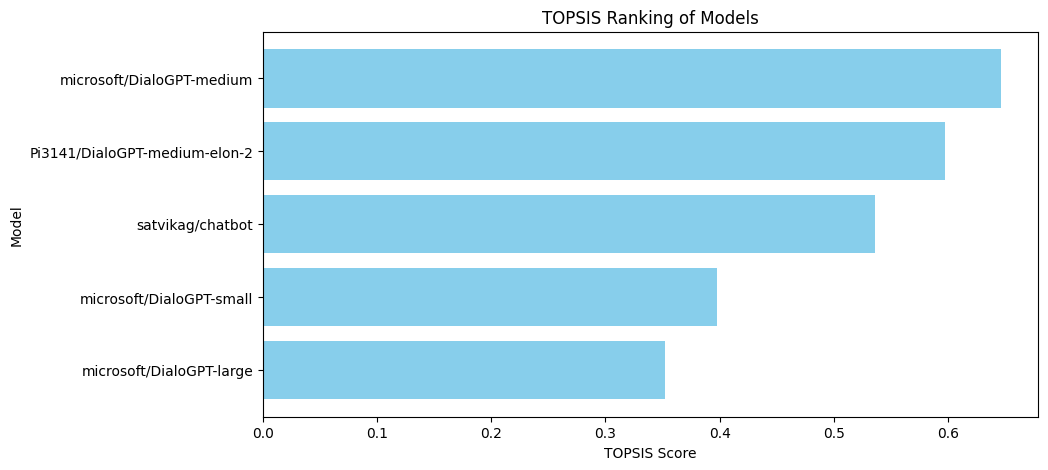

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

topsis_results = pd.read_csv("topsis.csv")

topsis_results_sorted = topsis_results.sort_values(by='Rank')


plt.figure(figsize=(10, 5))
plt.barh(topsis_results_sorted.iloc[:, 0], topsis_results_sorted['Topsis Score'], color='skyblue')
plt.xlabel('TOPSIS Score')
plt.ylabel('Model')
plt.title('TOPSIS Ranking of Models')
plt.gca().invert_yaxis()
plt.show()

In [12]:
topsis_results

,Unnamed: 0,BLEU,ROUGE-1,ROUGE-2,ROUGE-L,Response Length,Topsis Score,Rank
0,microsoft/DialoGPT-medium,0.0,0.227460,0.097214,0.196349,12.6,0.646817,1.0
1,Pi3141/DialoGPT-medium-elon-2,0.0,0.247084,0.093404,0.190259,12.0,0.597485,2.0
2,microsoft/DialoGPT-large,0.0,0.315608,0.131529,0.255640,8.4,0.351923,5.0
3,microsoft/DialoGPT-small,0.0,0.274286,0.139394,0.245714,7.2,0.397904,4.0
4,satvikag/chatbot,0.0,0.268946,0.142872,0.227464,9.0,0.536561,3.0
